## INFOSYS 722 Assignement Iteration 4 - Sub-iteration 2

In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math

In [3]:
spark = SparkSession.builder.appName('infosys722-i4-i2').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/12 00:59:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/10/12 00:59:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
integrated_purchase_detail = spark.read.options(compression='gzip').format('parquet').load(
    './Ready Datasets/purchase_detail_v001')
integrated_sales = spark.read.options(compression='gzip').format('parquet').load(
    './Ready Datasets/sales_v001')

In [5]:
period = 60

In [6]:
sales_frequency = integrated_sales.groupBy('Brand').agg(
    F.count('Brand').alias('count')).withColumn('Frequency', F.col('count') / period)

In [7]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor, LinearRegression, RandomForestRegressor
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator

import seaborn as sns


In [8]:
clustering = Pipeline(stages = [
    VectorAssembler(inputCols=['Frequency'], outputCol='features'), 
    KMeans(k=3, seed=13)])
cluster_model = clustering.fit(sales_frequency)    

In [9]:
result = cluster_model.transform(sales_frequency)

In [10]:
evaluator = ClusteringEvaluator(metricName='silhouette',  
                                distanceMeasure='squaredEuclidean')
evaluator.evaluate(result)

0.7969227246756405

<AxesSubplot:xlabel='prediction', ylabel='Frequency'>

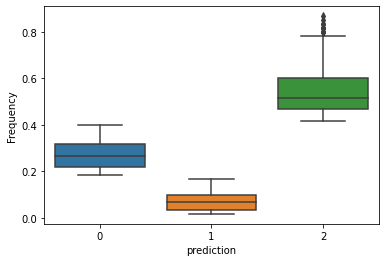

In [11]:
sns.boxplot(x='prediction', y='Frequency', data=result.toPandas())